In [1]:
import datetime
import numpy as np

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

import pandas as pd
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

### Combine train and test data for one-hot encoding

In [3]:
train["data"] = "train"
test["data"] = "test"

combined_data = pd.concat([train, test])
encoded = pd.get_dummies(combined_data[["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]])
drop_cat = combined_data.drop(["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"], axis=1)
combined_data_clean = drop_cat.join(encoded)

In [4]:
train_data = combined_data_clean[combined_data_clean.data == "train"].copy()
test_data = combined_data_clean[combined_data_clean.data == "test"].copy()

train_data.drop("data", axis=1, inplace=True)
test_data.drop(["data", "y"], axis=1, inplace=True)

In [5]:
train_data.columns

Index(['X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107',
       'X108',
       ...
       'X8_p', 'X8_q', 'X8_r', 'X8_s', 'X8_t', 'X8_u', 'X8_v', 'X8_w', 'X8_x',
       'X8_y'],
      dtype='object', length=580)

In [6]:
test_data.columns

Index(['X10', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107',
       'X108',
       ...
       'X8_p', 'X8_q', 'X8_r', 'X8_s', 'X8_t', 'X8_u', 'X8_v', 'X8_w', 'X8_x',
       'X8_y'],
      dtype='object', length=579)

In [8]:
y_train = train_data["y"].astype(np.float32)
x_train =  train_data.drop("y", axis=1).astype(np.float32)
x_test = test_data.astype(np.float32)

In [12]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit(x_train)
x_train = sel.transform(x_train)
x_test = sel.transform(x_test)

In [13]:
x_train.shape

(4209, 74)

In [14]:
train_reshaped = np.array([i.reshape((-1, 1)) for i in x_train])
train_reshaped = train_reshaped.astype(np.float32)
train_reshaped.shape

(4209, 74, 1)

### Train the model

In [15]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [16]:
rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
# Idea: Simple model

model = Sequential()
model.add(Bidirectional(SimpleRNN(128, return_sequences=True, activation="relu"), input_shape=(None, 1)))
model.add(Bidirectional(SimpleRNN(64, return_sequences=True, activation="relu")))
model.add(Bidirectional(SimpleRNN(32, return_sequences=False, activation="relu")))
model.add(Dense(1, activation="linear"))

model.compile(optimizer=rmsprop, loss="mse", metrics=[r2_keras])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 256)         33280     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         41088     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                10304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 84,737
Trainable params: 84,737
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Idea: Funnel -> reduce information after each layer / deep model


model = Sequential()
model.add(Bidirectional(SimpleRNN(128, return_sequences=True, activation="relu"), input_shape=(None, 1)))
model.add(Bidirectional(SimpleRNN(128, return_sequences=True, activation="relu")))
model.add(TimeDistributed(Dense(64, activation="relu")))
model.add(Bidirectional(SimpleRNN(64, return_sequences=True, activation="relu")))
model.add(Bidirectional(SimpleRNN(64, return_sequences=True, activation="relu")))
model.add(TimeDistributed(Dense(32, activation="relu")))
model.add(Bidirectional(SimpleRNN(32, return_sequences=False, activation="relu")))
model.add(Dropout(0.8))
model.add(Dense(1, activation="linear"))
model.compile(optimizer=rmsprop, loss="mse", metrics=[r2_keras])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, None, 256)         33280     
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 256)         98560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 64)          16448     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         16512     
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 128)         24704     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          4128      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                4160      
__________

In [ ]:
early_stop = EarlyStopping(monitor="loss", patience=10)
file_path = "test/weights.{epoch:02d}-{val_loss:.2f}-{val_r2_keras:.2f}.hdf5"
checkpoint = ModelCheckpoint(file_path)
model_run = model.fit(train_reshaped, y_train, epochs=500, batch_size=128, validation_split=0.02, callbacks=[checkpoint])

Train on 4124 samples, validate on 85 samples
Epoch 1/500
4124/4124 [==============================] - 18s - loss: 6787.7882 - r2_keras: -44.3832 - val_loss: 1831.9407 - val_r2_keras: -12.1252
Epoch 2/500
1152/4124 [=======>......................] - ETA: 12s - loss: 4605.1044 - r2_keras: -27.1267

In [ ]:
y_pred_train = model.predict(train_reshaped)

In [ ]:
print("the R2 score is : {}".format(r2_score(y_train, y_pred_train)))

In [20]:
model_loaded = load_model("test/weights.131-57.91-0.59.hdf5", custom_objects={"r2_keras": r2_keras})

In [21]:
y_pred_train = model_loaded.predict(train_reshaped)

In [22]:
print("the R2 score is : {}".format(r2_score(y_train, y_pred_train)))

the R2 score is : 0.5085551815593106


### Prediction

In [23]:
test_reshaped = np.array([i.reshape((-1, 1)) for i in x_test])
test_reshaped = test_reshaped.astype(np.float32)
test_reshaped.shape

(4209, 74, 1)

In [24]:
y_pred_test = model_loaded.predict(test_reshaped)

In [25]:
output = pd.DataFrame({"ID": test.index, "y": y_pred_test.reshape(-1)})

In [26]:
output.head()

,ID,y
0,1,77.991318
1,2,92.692093
2,3,84.159035
3,4,77.991318
4,5,111.706795


In [27]:
output.to_csv("submissions_{}.csv".format(datetime.datetime.today()), index=False)

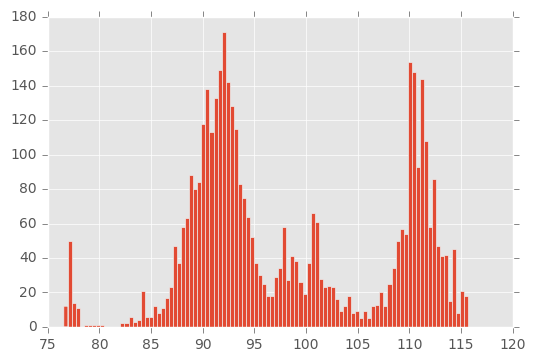

In [28]:
output.y.hist(bins=100)

### Combine submission

In [ ]:
sub_1 = pd.read_csv("submission_baseLine.csv")

In [ ]:
sub_2 = pd.read_csv("submissions_2017-05-31 15:48:40.546392.csv")

In [ ]:
sub_3 = output.copy()

In [ ]:
mean_pred = (sub_1.y.values + sub_2.y.values + sub_3.y.values) / 3

In [ ]:
output_mean = pd.DataFrame({"ID": test.index, "y": mean_pred})

In [ ]:
output_mean.to_csv("submissions_mean_{}.csv".format(datetime.datetime.today()), index=False)

In [ ]:
sub_1 = pd.read_csv("submission_baseLine.csv")

In [ ]:
sub_2 = pd.read_csv("submissions_2017-05-31 15:48:40.546392.csv")

In [ ]:
mean_pred = (sub_1.y.values + sub_2.y.values ) / 2

In [ ]:
output_mean = pd.DataFrame({"ID": test.index, "y": mean_pred})

In [ ]:
output_mean.to_csv("submissions_mean_2_{}.csv".format(datetime.datetime.today()), index=False)